In [1]:
using Graphs
using DocStringExtensions
using CairoMakie
using RNAStructPlot
using LinearAlgebra

sequence = "CGCUUCAUAUAAUCCUAAUGAUAUGGUUUGGGAGUUUCUACAUUAUGAAGUG"
notation = "...(((((((..((((((.........))))))......)...))))))..."

rnabase = dotbracketbase(
    sequence, 
    notation
)

ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.


RNABaseGraph(SimpleGraph{Int64}(64, [[2], [1, 3], [2, 4], [3, 5, 49], [4, 6, 48], [5, 7, 47], [6, 8, 46], [7, 9, 45], [8, 10, 44], [9, 11, 40]  …  [42, 44], [9, 43, 45], [8, 44, 46], [7, 45, 47], [6, 46, 48], [5, 47, 49], [4, 48, 50], [49, 51], [50, 52], [51]]), Dict{Any, Char}(5 => 'U', 16 => 'U', 20 => 'G', 35 => 'U', 30 => 'G', 19 => 'U', 32 => 'G', 49 => 'A', 6 => 'C', 45 => 'A'…), Dict{Any, Any}(5 => 48, 16 => 30, 7 => 46, 8 => 45, 17 => 29, 13 => 33, 6 => 47, 15 => 31, 4 => 49, 10 => 40…))

In [2]:
function draw_generic(
    rnastruct::RNABaseGraph, drawresult::DrawResult;
    basecolors=Dict('A' => :red,'G' => :cyan,'C' => :yellow,'U' => :lime),
    bondcolor=:red,
    showstrength=true,
    shownumberings=true,
    showstart=true
)

    graph = rnastruct.graph
    bases = rnastruct.nucleotides

    coords = drawresult.coords
    numberings = drawresult.numberings

    f = Figure()
    ax = Axis(f[1,1], aspect = DataAspect())

    # draw edges
    for e in edges(graph)
        sx, sy = coords[src(e)]
        dx, dy = coords[dst(e)]

        # change style if bases are paired
        ispair = haspair(rnastruct, src(e), dst(e))
        edgecolor = ispair ? bondcolor : :black
        strength = showstrength && ispair ? bondstrength(rnastruct, src(e), dst(e)) : 0

        lines!([sx, dx], [sy, dy];linestyle=(:dash, strength^1.8),color=edgecolor)
    end

    # draw vertices with specified coloring
    xs = [coords[v][1] for v in vertices(graph)]
    ys = [coords[v][2] for v in vertices(graph)]
    colors = [basecolors[bases[v]] for v in vertices(graph)]
    scatter!(xs, ys, markersize=20, color=colors)

    # draw nucleotide base labels
    for v in vertices(graph)
        text!(coords[v][1], coords[v][2] ,text=string(bases[v]),align=(:center, :center))
    end
    # draw numbering labels if enabled
    if shownumberings
        for i in vcat([1], range(0,nv(graph), step=5))
            if has_vertex(graph, i) && haskey(coords, i)
                text!(numberings[i][1], numberings[i][2],text=string(i),align=(:center, :center))
            end
        end
    end
    # draw starting arrow pointing to first base in sequence if enabled
    if showstart
        curve = bezier1(coords[1], numberings[1])
        tipx, tipy = arrowtip = curve(0.3)
        tailx, taily = arrowtail = curve(0.8)
        arrows2d!([tailx], [taily], [tipx-tailx], [tipy-taily])
    end
    hidespines!(ax)
    hidedecorations!(ax)
    current_figure()
end

draw_generic (generic function with 1 method)

In [3]:
function layoutcircular(rnabase::RNABaseGraph)
    graph = rnabase.graph
    coords = Dict()
    numberings = Dict()

    # walk along circle
    for (i, vertex) in enumerate(vertices(graph))
        x = (i-1)/nv(graph) * 2 * pi
        coords[vertex] = [cos(x), sin(x)]
        numberings[vertex] = coords[vertex] * 1.1
    end
    return DrawResult(coords, numberings)
end

layoutcircular (generic function with 1 method)

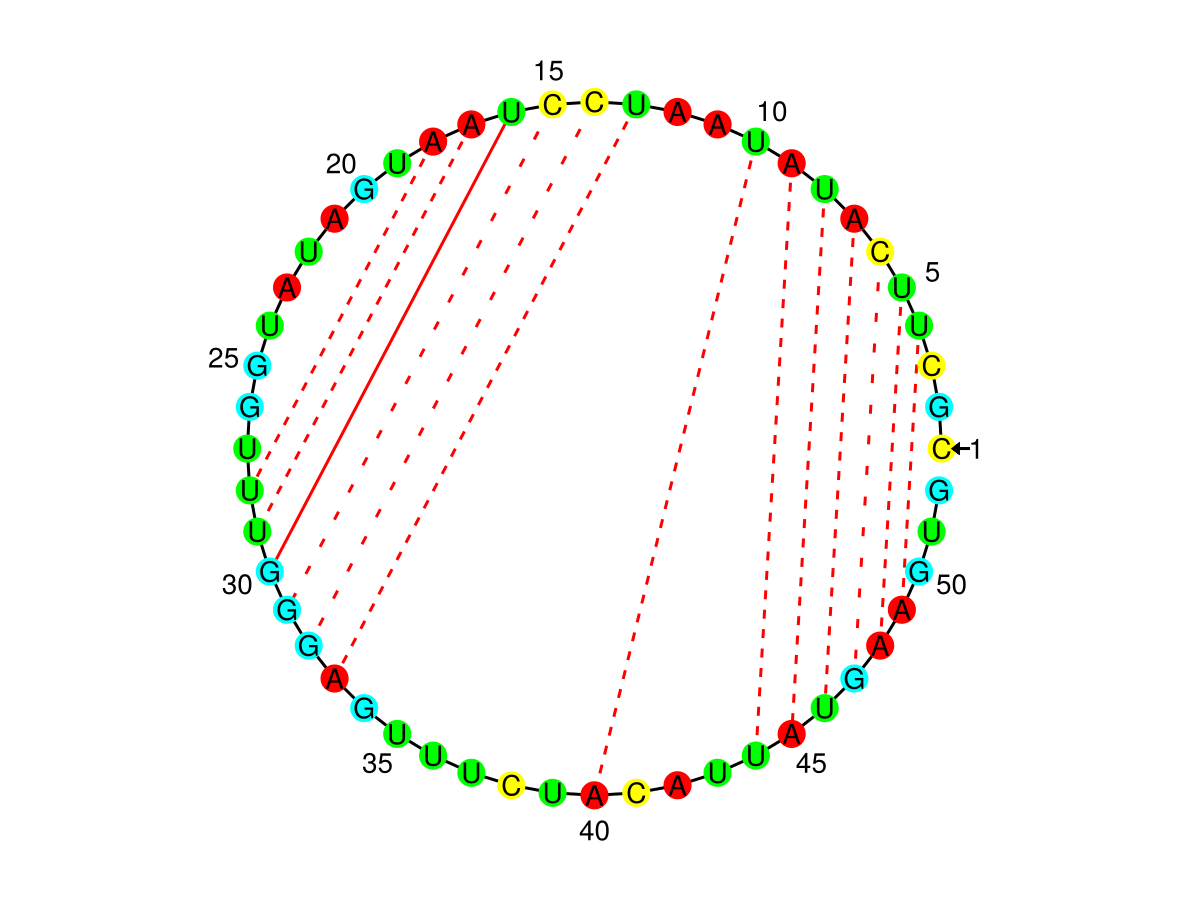

In [4]:
result = layoutcircular(rnabase)


drawgeneric(rnabase, result)

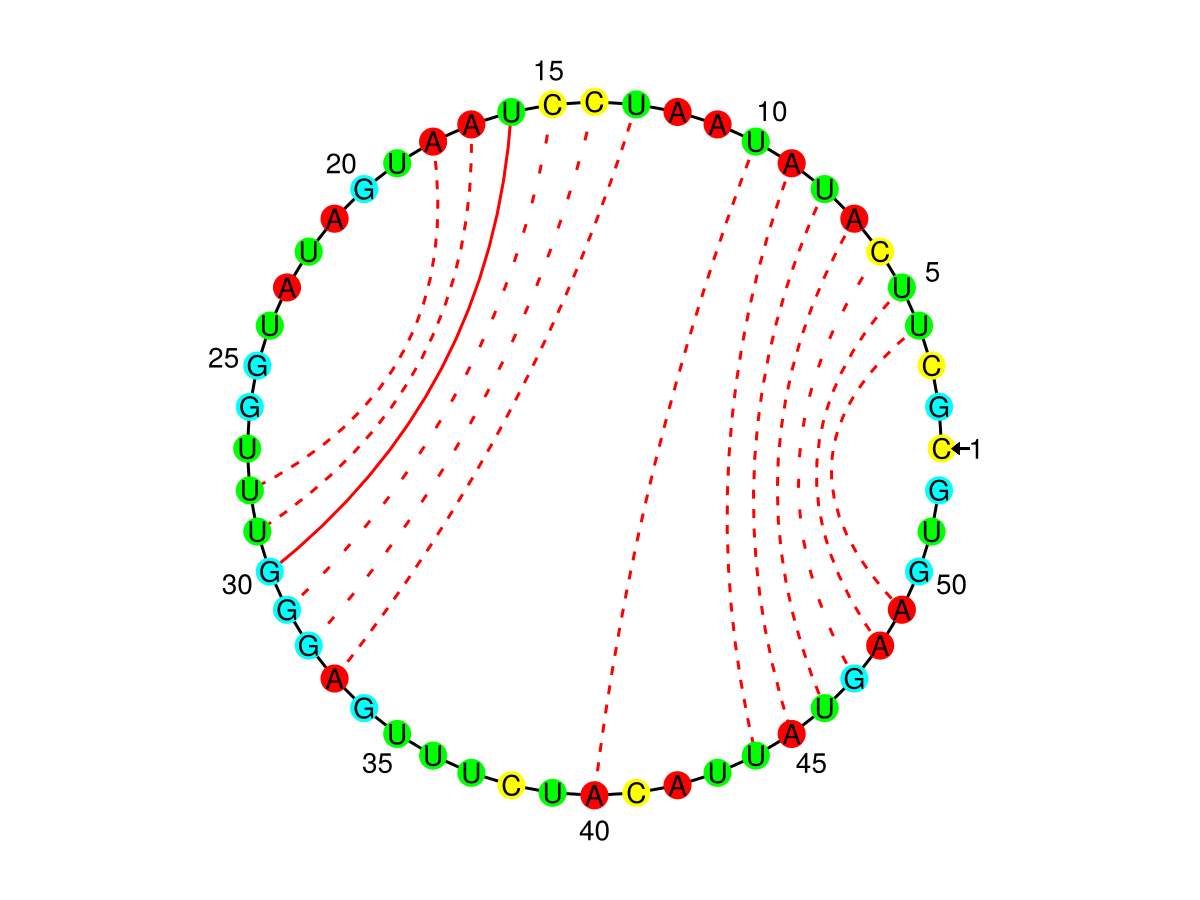

In [5]:
function draw_bezier(
    rnastruct::RNABaseGraph, drawresult::DrawResult;
    basecolors=Dict('A' => :red,'G' => :cyan,'C' => :yellow,'U' => :lime),
    bondcolor=:red,
    showstrength=true,
    shownumberings=true,
    showstart=true,
    precision=16,
    curvebend=2
)

    graph = rnastruct.graph
    bases = rnastruct.nucleotides

    coords = drawresult.coords
    numberings = drawresult.numberings

    f = Figure()
    ax = Axis(f[1,1], aspect = DataAspect())

    # draw edges
    for e in edges(graph)
        source = sx, sy = coords[src(e)]
        desination = dx, dy = coords[dst(e)]

        # change style if bases are paired
        ispair = haspair(rnastruct, src(e), dst(e))
        edgecolor = ispair ? bondcolor : :black
        strength = showstrength && ispair ? bondstrength(rnastruct, src(e), dst(e)) : 0

        # draw bezier curve
        if ispair
            mid = (source + (desination - source)/2)/curvebend
            bez2 = bezier2(source, mid, desination)

            intervals = 16
            curvex, curvey = [], []
            zerox, zeroy =  bez2(0)
            push!(curvex, zerox)
            push!(curvey, zeroy)

            for i in range(1, intervals)
                x = (i-1)/intervals
                nextx, nexty = bez2(i/intervals)

                push!(curvex, nextx)
                push!(curvey, nexty)
            end
            lines!(curvex, curvey;linestyle=(:dash, strength^1.8), color=edgecolor)
        else
            lines!([sx, dx], [sy, dy];color=edgecolor)
        end
    end

    # draw vertices with specified coloring
    xs = [coords[v][1] for v in vertices(graph)]
    ys = [coords[v][2] for v in vertices(graph)]
    colors = [basecolors[bases[v]] for v in vertices(graph)]
    scatter!(xs, ys, markersize=20, color=colors)

    # draw nucleotide base labels
    for v in vertices(graph)
        text!(coords[v][1], coords[v][2] ,text=string(bases[v]),align=(:center, :center))
    end
    # draw numbering labels if enabled
    if shownumberings
        for i in vcat([1], range(0,nv(graph), step=5))
            if has_vertex(graph, i) && haskey(coords, i)
                text!(numberings[i][1], numberings[i][2],text=string(i),align=(:center, :center))
            end
        end
    end
    # draw starting arrow pointing to first base in sequence if enabled
    if showstart
        curve = bezier1(coords[1], numberings[1])
        tipx, tipy = arrowtip = curve(0.3)
        tailx, taily = arrowtail = curve(0.8)
        arrows2d!([tailx], [taily], [tipx-tailx], [tipy-taily])
    end
    hidespines!(ax)
    hidedecorations!(ax)
    current_figure()
end

draw_bezier(rnabase, result)